# ANN using TensorFlow

In this part we will be using TensorFlow library to build the ANN model for chess problem.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('chesscom_games_no_draws.csv')

In [3]:
df.head(3)

,Unnamed: 0,Event,Site,Date,Round,Time Control,Time,Color,Opening move,Opponent,Opponent location,Current Rank,Opponent Rank,Result,Reason,Hour,Previously played that day
0,0,Live Chess,Chess.com,2018.08.15,-,180+2,22:34:39,White,e4,Lillyandmarcus,United States,614,736,Lost,Resignation,22,0
1,1,Live Chess,Chess.com,2018.09.18,-,180+2,15:34:13,White,d4,TheGod1092,United States,741,537,Won,Checkmate,15,0
2,2,Live Chess,Chess.com,2018.09.18,-,180+2,17:28:39,Black,e4,joseinstein,International,666,887,Lost,Resignation,17,1


Creating the Rank difference column and dummy variables for Color and Cime Control columns; also replacing the string value to a numeric value in the Result column:

In [4]:
df['Rank difference'] = df['Current Rank'] - df['Opponent Rank']
df.drop(['Unnamed: 0', 'Event','Site','Date','Round','Time',
         'Opponent','Opponent location','Opening move','Reason', 'Current Rank'], 
        axis=1,inplace=True)
df['Time Control'] = df['Time Control'].apply(lambda x: 0 if x == '300+5' else 1)
df['Result'] = df['Result'].apply(lambda x: 0 if x == 'Won' else 1)
df['Color'] = df['Color'].apply(lambda x: 0 if x == 'White' else 1)

Removing white spaces from the column names and perfoming Feature scaling:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('Result',axis=1))
df.columns = ['Time_Control','Color','Opponent_Rank','Result','Hour','Previously_played_that_day','Rank_difference']
scaled_features = scaler.fit_transform(df.drop('Result',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[[0,1,2,4,5,6]])

In [6]:
df_feat.head(5)

,Time_Control,Color,Opponent_Rank,Hour,Previously_played_that_day,Rank_difference
0,2.336615,-0.985865,-0.303326,1.165555,-0.910811,-1.234530
1,2.336615,-0.985865,-1.937241,0.117248,-0.910811,2.532951
2,2.336615,1.014338,0.936479,0.416765,-0.825405,-2.378642
3,2.336615,1.014338,-0.336168,0.416765,-0.740000,-1.488777
4,2.336615,-0.985865,-1.206495,0.416765,-0.654595,-1.072736


Make sure there is no missing data:

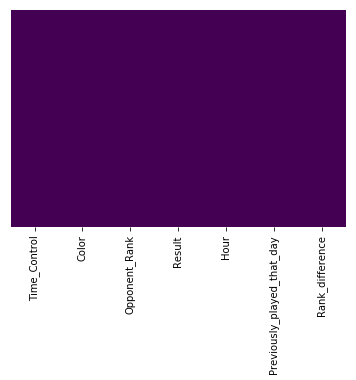

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Selecting our depentent and independent variables and splitting the dataset into test set and training set:

In [8]:
X = df_feat
y = df['Result']

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

Creating the ANN:

In [10]:
import tensorflow as tf

/Users/puzanov/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Feature columns:

In [11]:
df_feat.columns

Index(['Time_Control', 'Color', 'Opponent_Rank', 'Hour',
       'Previously_played_that_day', 'Rank_difference'],
      dtype='object')

In [12]:
time_control = tf.feature_column.numeric_column('Time_Control')
color = tf.feature_column.numeric_column('Color')
opponent_rank = tf.feature_column.numeric_column('Opponent_Rank')
hour = tf.feature_column.numeric_column('Hour')
prev_played = tf.feature_column.numeric_column('Previously_played_that_day')
rank_difference = tf.feature_column.numeric_column('Rank_difference')

In [13]:
feat_cols = [time_control,color,opponent_rank,hour,prev_played,rank_difference]

In [14]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train,y=y_train,batch_size=20,shuffle=True)
classifier = tf.estimator.DNNClassifier(hidden_units=[10], n_classes=2,feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_device_fn': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_worker_replicas': 1, '_global_id_in_cluster': 0, '_session_config': None, '_task_type': 'worker', '_tf_random_seed': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_master': '', '_log_step_count_steps': 100, '_is_chief': True, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10536e4a8>, '_model_dir': '/var/folders/fw/1t8yw6_92z7_zg5vwp8c1r0w0000gn/T/tmpymzcnby8', '_service': None, '_train_distribute': None}


Training the NN:

In [15]:
classifier.train(input_fn=input_func,steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/fw/1t8yw6_92z7_zg5vwp8c1r0w0000gn/T/tmpymzcnby8/model.ckpt.
INFO:tensorflow:loss = 13.037428, step = 1
INFO:tensorflow:Saving checkpoints for 40 into /var/folders/fw/1t8yw6_92z7_zg5vwp8c1r0w0000gn/T/tmpymzcnby8/model.ckpt.
INFO:tensorflow:Loss for final step: 3.6302109.


Model evaluation:

In [16]:
pred_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,batch_size=len(X_test),shuffle=False)
note_predictions = list(classifier.predict(input_fn=pred_fn))
#note_predictions[0]
final_pred  = []
for pred in note_predictions:
    final_pred.append(pred['class_ids'][0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/fw/1t8yw6_92z7_zg5vwp8c1r0w0000gn/T/tmpymzcnby8/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Visualizing the results:

In [17]:
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, final_pred)
print(cm)
(cm[0][0]+cm[1][1])/(len(y_test))

[[130  53]
 [ 54 101]]


0.6834319526627219

# Thank you!